# GBM local interpretation

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

Here I show how to make local interpretations for a regression model, but the code for classification is the same. We just need to change the model class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


### Split data

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 6), (6192, 6))

## GBM

In [4]:
# fit model

gbm = GradientBoostingRegressor(
    criterion="squared_error",
    n_estimators=2,
    max_depth=3,
    random_state=3,
)

gbm.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', n_estimators=2,
                          random_state=3)

## Plot ensemble

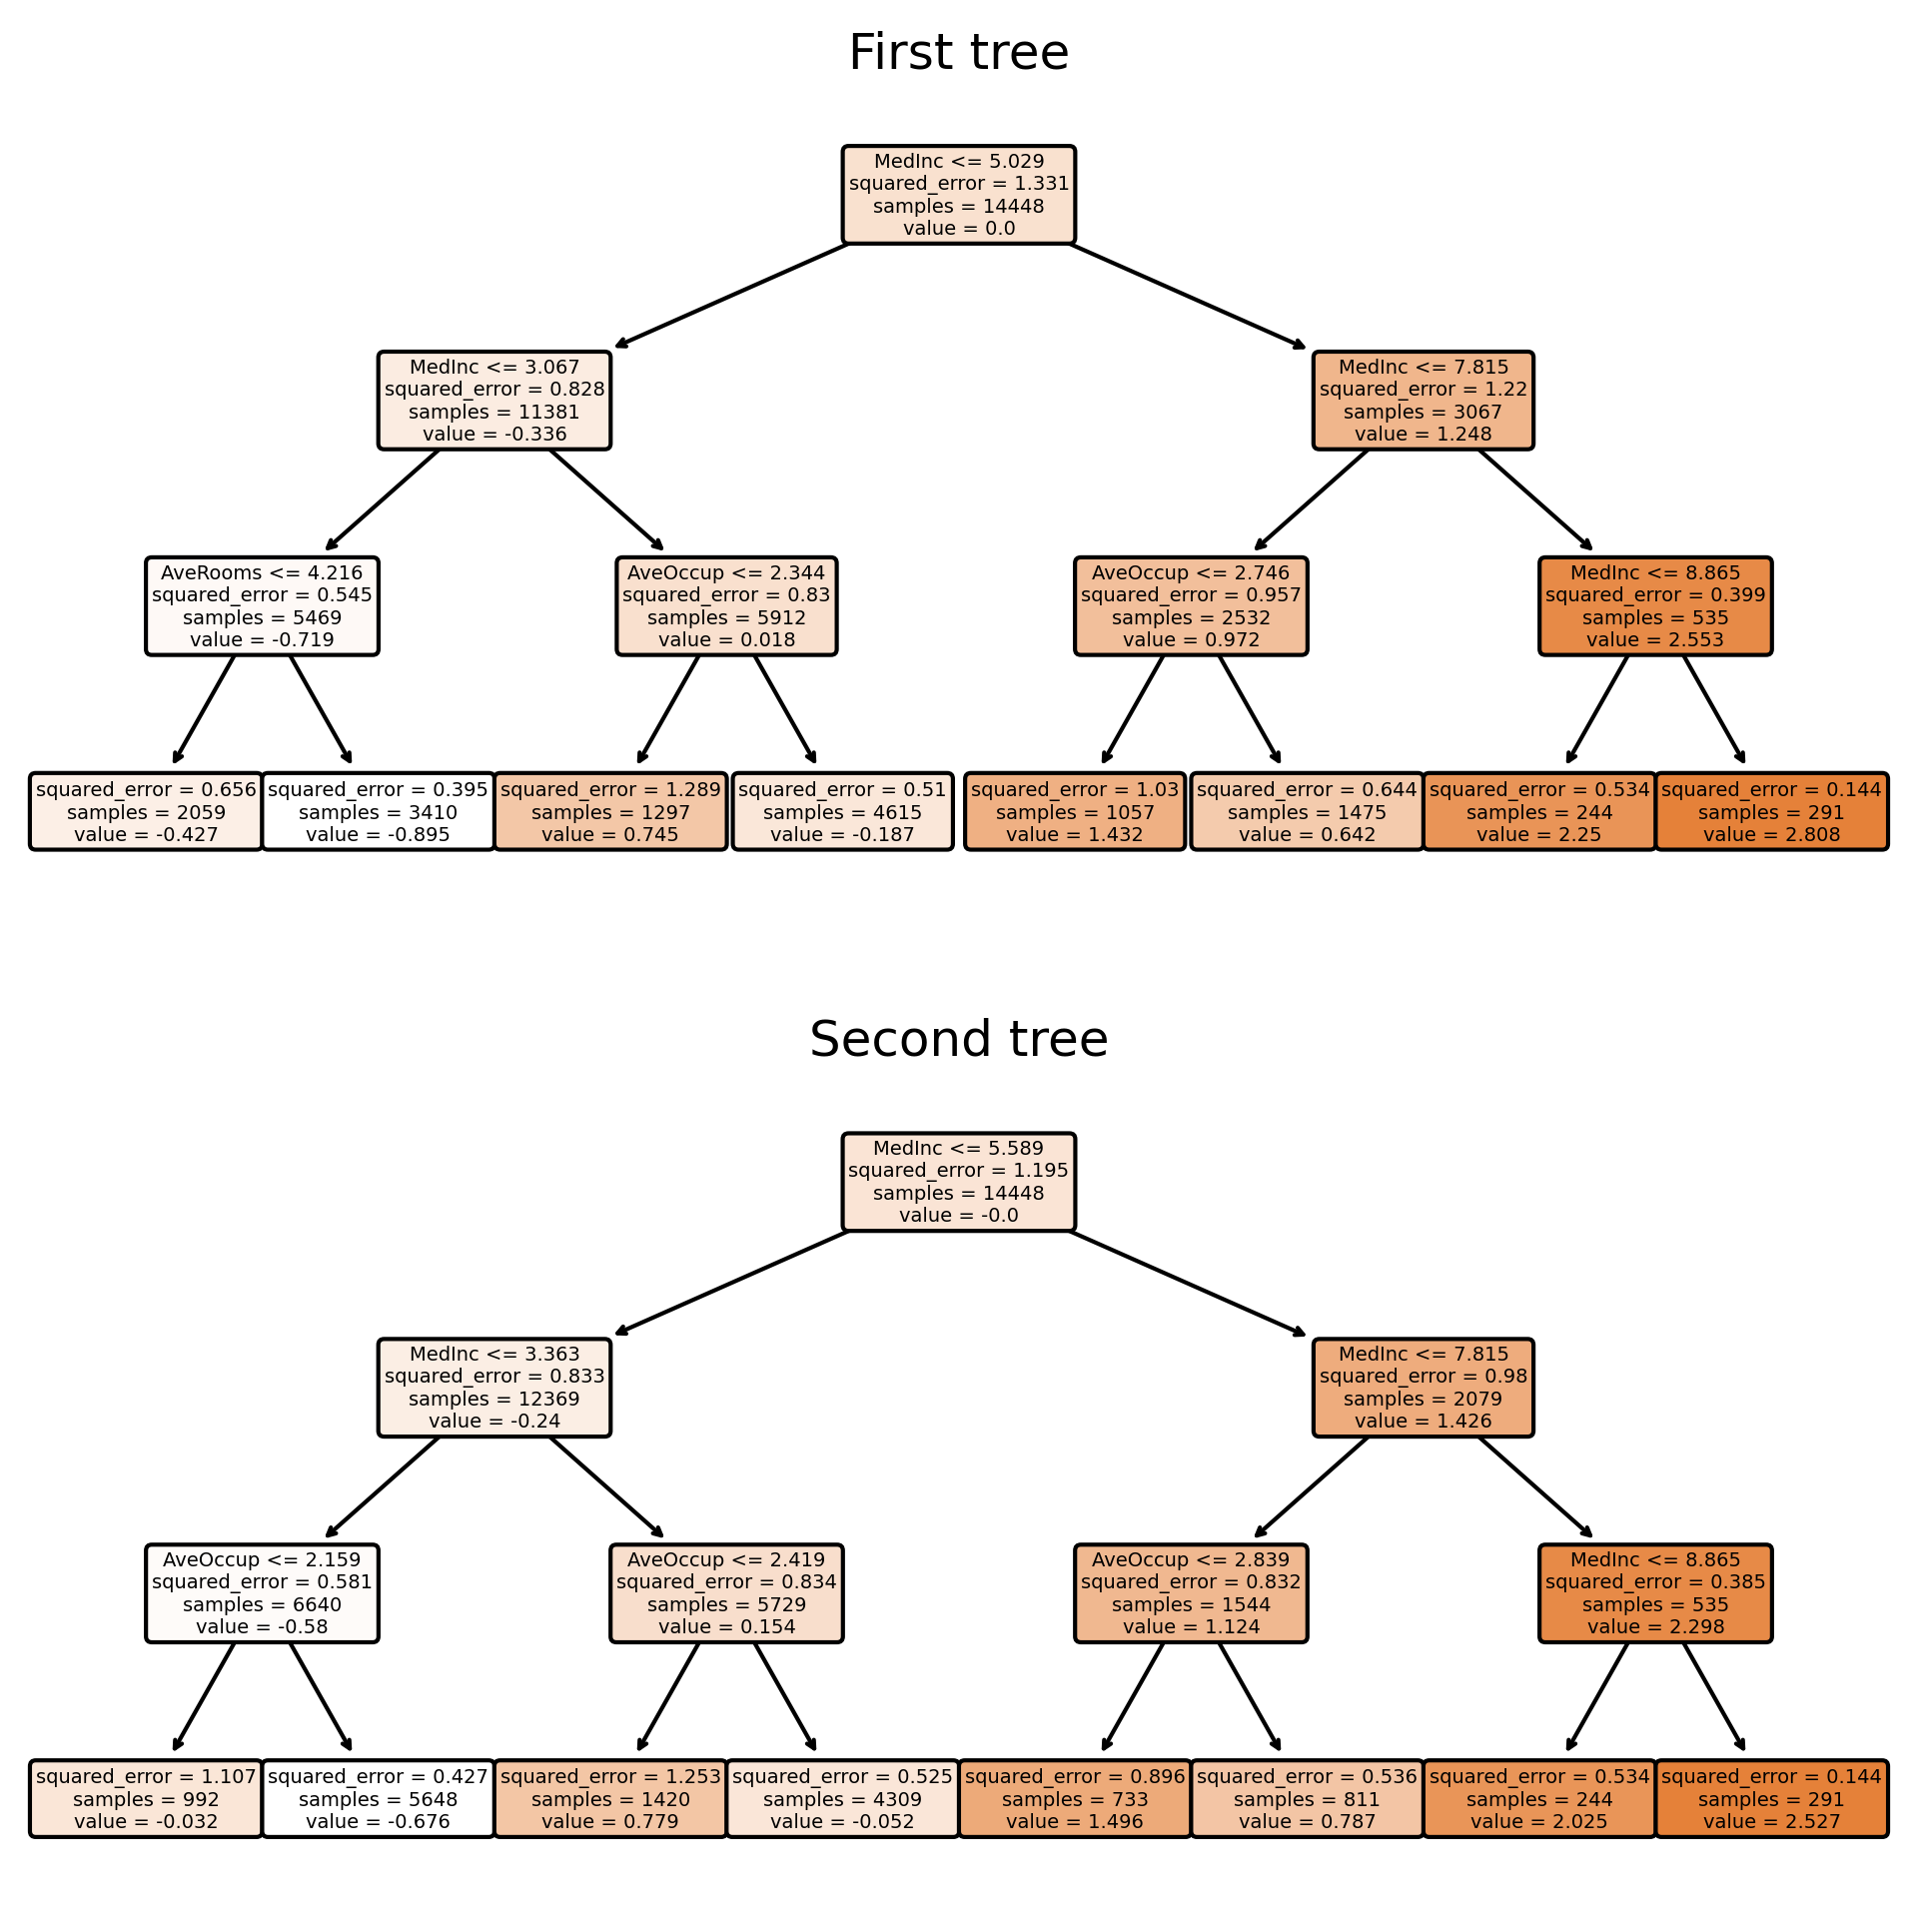

In [5]:
plt.figure(figsize=(8, 8), dpi=300)

# first tree
plt.subplot(2, 1, 1)
plot_tree(
    decision_tree=gbm.estimators_[0][0],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True,  # round squares
)
plt.title("First tree")


# second tree
plt.subplot(2, 1, 2)
plot_tree(
    decision_tree=gbm.estimators_[1][0],
    feature_names=X_train.columns.to_list(),
    filled=True,  # color the squares
    rounded=True,  # round squares
)
plt.title("Second tree")

plt.show()

## Feature contribution

Remember that trees are additive in GBMs!!

In [6]:
# Display a few observations from test set

X_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401


In [7]:
# pick one observation

sample_id = 14740

X_test.loc[sample_id]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Name: 14740, dtype: float64

In [8]:
# tree one

# feature contribution = value in child - value in parent

first_split = -0.336 - 0
second_split = 0.018 - (-0.336)
third_split = -0.187 - 0.018

MedianInc_t1 = first_split + second_split
AveOccup_t1 = third_split

MedianInc_t1, AveOccup_t1

(0.018000000000000016, -0.205)

In [9]:
# tree two

first_split = -0.24 - 0
second_split = 0.154 - (-0.24)
third_split = -0.052 - 0.154

MedianInc_t2 = first_split + second_split
AveOccup_t2 = third_split

MedianInc_t2, AveOccup_t2

(0.15400000000000003, -0.206)

In [10]:
# The contributions are cumulative 
# (not the average like in random forests)

MedInc = MedianInc_t1 + MedianInc_t2
AveOccup = AveOccup_t1 + AveOccup_t2

MedInc, AveOccup

(0.17200000000000004, -0.411)

In [11]:
# the bias

y_mean =  y_train.mean()

y_mean

2.0682462451550387

In [12]:
# the weight

w = gbm.learning_rate

w

0.1

In [13]:
# prediction, calculated manually

y_mean + (w * MedInc) + (w * AveOccup)

2.0443462451550385

In [14]:
# prediction of the random forests

gbm.predict(X_test.loc[sample_id].to_frame().T)

array([2.04440149])

In [15]:
# The feature contribution across trees

# Remember that it is the weighted contribution

MedInc = MedInc * w
AveOccup = AveOccup * w

MedInc, AveOccup

(0.017200000000000003, -0.0411)

In [16]:
# Same calculation as in cell 12

y_mean + MedInc + AveOccup

2.0443462451550385

## Eli5

If you have problems to import eli5 with the latest version of sklearn, you need to go to the eli5 files that are stored in your local computer, and change a few lines of code as shown in [this PR](https://github.com/eli5-org/eli5/commit/840695d869e47b8e6cc05baca428d24881113fb6)

More details also available [here](https://github.com/eli5-org/eli5/issues/39)

In [17]:
import eli5

## Global explanations

In [18]:
# feature importance (global)

eli5.show_weights(gbm, feature_names=gbm.feature_names_in_)

Weight,Feature
0.8494 ± 0.0014,MedInc
0.1357 ± 0.0287,AveOccup
0.0150 ± 0.0273,AveRooms
0 ± 0.0000,Population
0 ± 0.0000,AveBedrms
0 ± 0.0000,HouseAge


In [19]:
# Compare with values from sklearn

pd.Series(
    gbm.feature_importances_,
    index=gbm.feature_names_in_,
).sort_values(ascending=False)

MedInc        0.849363
AveOccup      0.135663
AveRooms      0.014975
HouseAge      0.000000
AveBedrms     0.000000
Population    0.000000
dtype: float64

## Local explanations

In [20]:
# Feature contributions (for 1 sample)

eli5.show_prediction(
    gbm, 
    X_test.loc[sample_id], 
    feature_names=gbm.feature_names_in_,
)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


If you get an error with the former command do the following:

- Change: 

```
elif is_grad_boost and hasattr(clf.loss_, 'get_init_raw_predictions'):
    bias_init = clf.loss_.get_init_raw_predictions(
        X, clf.init_).astype(np.float64)[0]
```

- to:

```
elif is_grad_boost and hasattr(clf._loss, 'get_init_raw_predictions'):
    bias_init = clf._loss.get_init_raw_predictions(
        X, clf.init_).astype(np.float64)[0]
```

in file `\lib\site-packages\eli5\sklearn\explain_prediction.py:584`

In [21]:
# let's pick another observation

X_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401


In [22]:
# let's evalute the feature contribution

eli5.show_prediction(
    gbm, 
    X_test.loc[10101], 
    feature_names=gbm.feature_names_in_,
)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [23]:
# if we want to obtain a dataframe instead of the 
# html output

eli5.explain_prediction_df(
    gbm, 
    X_test.loc[10101], 
    feature_names=gbm.feature_names_in_,
)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


,target,feature,weight,value
0,y,<BIAS>,2.068246,1.000000
1,y,MedInc,0.209539,5.779600
2,y,AveOccup,-0.066599,3.020979
